In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.jet()

import sys
sys.path.insert(0, '../')
from M1S_tools import *
import glob

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_165SA_09Jan2025/
Afz =  (27547, 165)
U matrix (27547, 165)
S matrix (165, 165)

<Figure size 640x480 with 0 Axes>

In [2]:
_, filesetM = parse_ml_data_folder('%s/Sec 14/'%(ml_data_dir))

Fri Jan 31 14:34:51 2025 	 250131 GMT3 set1 Act209 14-2-5 Initial gmtMorph170614 -.h5
Fri Jan 31 14:39:30 2025 	 250131 GMT3 set1 Act209 14-2-8 gmtMorph170614 -.h5
Fri Jan 31 14:43:52 2025 	 250131 GMT3 set1 Act209 14-2-11 gmtMorph170614 -.h5
Fri Jan 31 14:47:57 2025 	 250131 GMT3 set1 Act306 14-2-5 Initial gmtMorph170614 -.h5
Fri Jan 31 14:52:20 2025 	 250131 GMT3 set1 Act306 14-2-8 gmtMorph170614 -.h5
Fri Jan 31 14:56:27 2025 	 250131 GMT3 set1 Act306 14-2-11 gmtMorph170614 -.h5


In [3]:
mysaID = 209
glob_string = '%s/Sec 14/*Act%d*14-2-5*-.h5'%(ml_data_dir,mysaID)
fileset = sorted(glob.glob(glob_string))
#print(glob_string, len(fileset))
assert len(fileset)==1
m1s5,centerRow,centerCol,pixelSize, ts5 = readH5Map(fileset) #, verbose=False)

/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 14/250131 GMT3 set1 Act209 14-2-5 Initial gmtMorph170614 -.h5: Fri Jan 31 14:34:51 2025 


### Pick one

In [4]:
#mysaID = 209
mysaID = 306

In [5]:
glob_string = '%s/Sec 14/*Act%d*14-2-5*-.h5'%(ml_data_dir,mysaID)
fileset = sorted(glob.glob(glob_string))
#print(glob_string, len(fileset))
assert len(fileset)==1
m1s5,centerRow,centerCol,pixelSize, ts5 = readH5Map(fileset) #, verbose=False)

/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 14/250131 GMT3 set1 Act306 14-2-5 Initial gmtMorph170614 -.h5: Fri Jan 31 14:47:57 2025 


In [6]:
glob_string = '%s/Sec 14/*Act%d*14-2-8*-.h5'%(ml_data_dir,mysaID)
fileset = sorted(glob.glob(glob_string))
#print(glob_string, len(fileset))
assert len(fileset)==1
m1s8,centerRow,centerCol,pixelSize, ts8 = readH5Map(fileset) #, verbose=False)

m1s = m1s8 - m1s5  #we will look at the change in surface
m1s = -m1s.T

[x1, y1] = mkXYGrid(m1s, centerCol, centerRow, pixelSize)

/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 14/250131 GMT3 set1 Act306 14-2-8 gmtMorph170614 -.h5: Fri Jan 31 14:52:20 2025 


SA306, Scaling factor =863.989, Residual RMS = 90.048 nm (per N force)


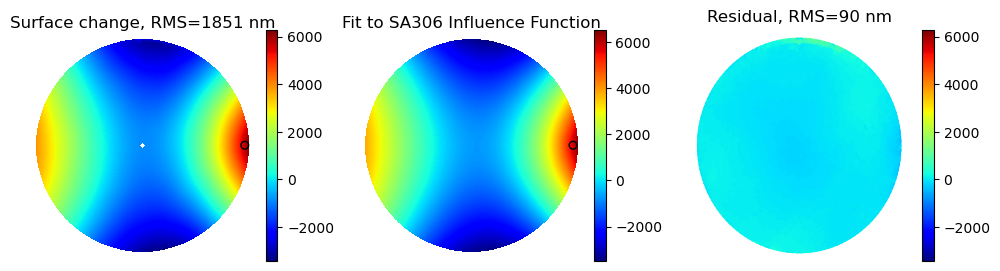

In [7]:
from scipy.interpolate import LinearNDInterpolator 

fig, ax = plt.subplots(1,3,figsize=(12,3))
img = ax[0].imshow(m1s*1000, origin='lower')
fig.colorbar(img, ax=ax[0])

m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
ax[0].set_title('Surface change, RMS=%.0f nm'%(m1rms))
ax[0].axis('off')

if2d = m1s*1000 #myIF is already in M1B, now it is in nm
mask = ~np.isnan(if2d)

interp = LinearNDInterpolator(list(zip(x1[mask], y1[mask])), if2d[mask], fill_value=0)
mapOntoGMTFEgrid = interp(nodex, nodey).ravel()
validIdx = mapOntoGMTFEgrid!=0
mapOntoGMTFEgrid[~validIdx] = np.nan
scaleF = np.linalg.pinv(Afz170[validIdx,saID==mysaID].reshape((-1,1))*1e9)  @ mapOntoGMTFEgrid[validIdx] #all in nm
residual = mapOntoGMTFEgrid - scaleF* np.squeeze(Afz170[:,saID==mysaID])*1e9 #this is residual
residual[np.isnan(residual)] = 0

modeID = np.argmax(saID==mysaID)+1
grid_z = griddata((nodex, nodey), Afz[:,modeID-1]*1e9*scaleF, (x1,y1), method='linear')
img = ax[1].imshow(grid_z, origin = 'lower')
fig.colorbar(img, ax=ax[1])
ax[1].set_title('Fit to SA%d Influence Function'%mysaID)
ax[1].axis('off')

m1rms = np.std(residual[~np.isnan(residual)]) #already in nm
mytitle = 'SA%d, Scaling factor =%.3f, Residual RMS = %.3f nm (per N force)'%(mysaID, scaleF, m1rms)
print(mytitle)

img = ax[2].scatter(nodex, nodey, 10, residual,vmin=np.nanmin(m1s*1000), vmax=np.nanmax(m1s*1000)) #-----------
fig.colorbar(img, ax=ax[2])
ax[2].set_title('Residual, RMS=%.0f nm'%(m1rms))
ax[2].axis('off')

for i in range(3):
    circle = plt.Circle((saID2pixx(mysaID, centerRow, centerCol, pixelSize), 
                         saID2pixy(mysaID, centerRow, centerCol, pixelSize)),15, fill=False)
    ax[i].add_artist(circle)

In [31]:
sa_force1, tt = getDBData(unix_ts(ts5)-120,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=60, samples=120)
sa_force1_ave = np.mean(sa_force1,axis=0)
print(sa_force1.shape)

m1_s1_support_ctrl/s/sa_force/value
2025-01-31 14:32:51  duration =  60  s
(120, 170, 3)
(120, 170, 3)


-1038.9259033203125
[-0.93135508]  compared to 0.941 obtained in Section 9 for SA209


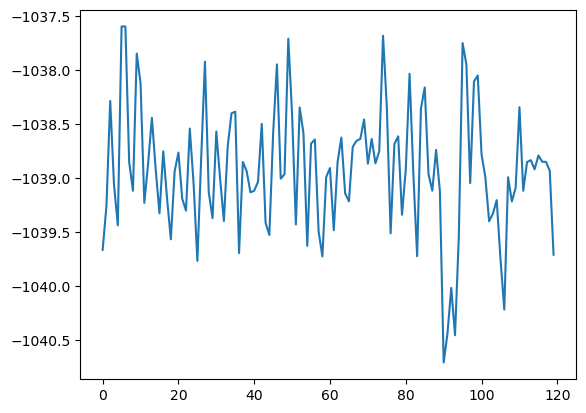

In [36]:
plt.plot(sa_force1[:,saID==mysaID, 2])
aa = sa_force1_ave[saID==mysaID, 2][0]
print(aa)
print(scaleF/aa, ' compared to 0.941 obtained in Section 9 for SA209')

### Below is probably not needed. Just for fun, we fit the difference map to Zernikes and bending modes.

Note that with an SA missing the bending modes still assumes all SAs are working.. The correction may take multiple iterations to converge.

### the fit to zernike does show a localized bump that won't be correctable at all by actuators.

In [25]:
nzer = 500
[x1, y1] = mkXYGrid(m1s, centerRow, centerCol, pixelSize)
r1 = np.sqrt(x1**2 + y1**2)

nnodes = x1.shape[0]*x1.shape[1]
zerU = np.zeros((nnodes, nzer))
for i in range(nzer):
    zerU[:,i] = zernike_polynomial(i+1, x1/radius_of_CA, y1/radius_of_CA).flatten()

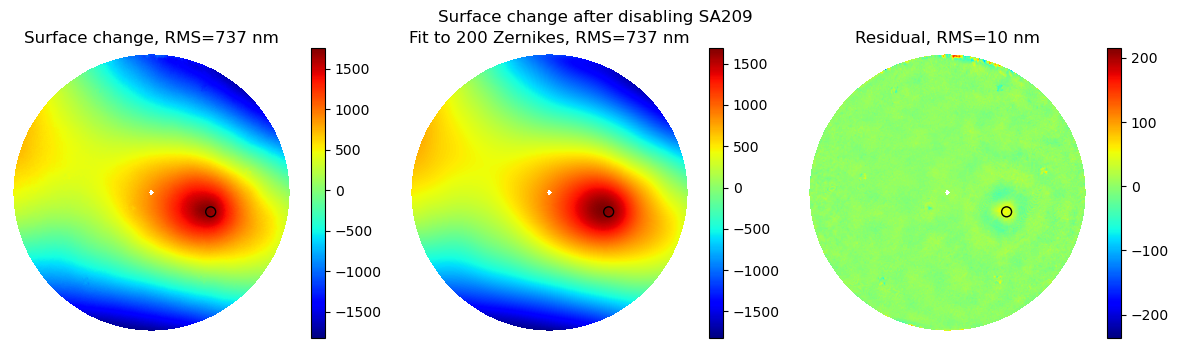

In [96]:
nzerUse = 200
fig, ax = plt.subplots(1,3,figsize=(12,3.5))
img = ax[0].imshow(m1s*1000, origin='lower')
fig.colorbar(img, ax=ax[0])
fig.suptitle('Surface change after disabling SA%d'%mysaID)
m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
ax[0].set_title('Surface change, RMS=%.0f nm'%(m1rms))
ax[0].axis('off')

maskNew = (~np.isnan(m1s) ) & (r1<radius_of_CA)
nnodesNew = np.sum(maskNew)
mycoeff = zerU[maskNew.flatten(),:nzerUse].transpose() / nnodesNew @ m1s[maskNew]
recon = np.zeros_like(m1s)
recon[~maskNew] = np.nan
for k in range(nzerUse):
    recon[maskNew] += mycoeff[k]*zerU[maskNew.flatten(),k]  
img = ax[1].imshow(recon*1000, origin='lower')          
fig.colorbar(img, ax=ax[1])
m1rms = np.std(recon[~np.isnan(recon)])*1000 #convert into nm
ax[1].set_title('Fit to %d Zernikes, RMS=%.0f nm'%(nzerUse, m1rms))
ax[1].axis('off')

residual = m1s-recon
img = ax[2].imshow(residual*1000, origin='lower')
fig.colorbar(img, ax=ax[2])
m1rms = np.std(residual[~np.isnan(residual)])*1000 #convert into nm
ax[2].set_title('Residual, RMS=%.0f nm'%(m1rms))
ax[2].axis('off')

for i in range(3):
    circle = plt.Circle((saID2pixx(mysaID, centerRow, centerCol, pixelSize), 
                         saID2pixy(mysaID, centerRow, centerCol, pixelSize)),15, fill=False)
    ax[i].add_artist(circle)
    
if 0:
    ax[2].plot(np.arange(1,nzer+1),mycoeff,'-o')
    ax[2].set_title('Zernike change after holding BM14 for 1.5 h')
    ax[2].grid()
    ax[2].set_ylabel(r'$\mu$m')
    ax[2].set_xlabel('Noll Zernike Index')
plt.tight_layout()

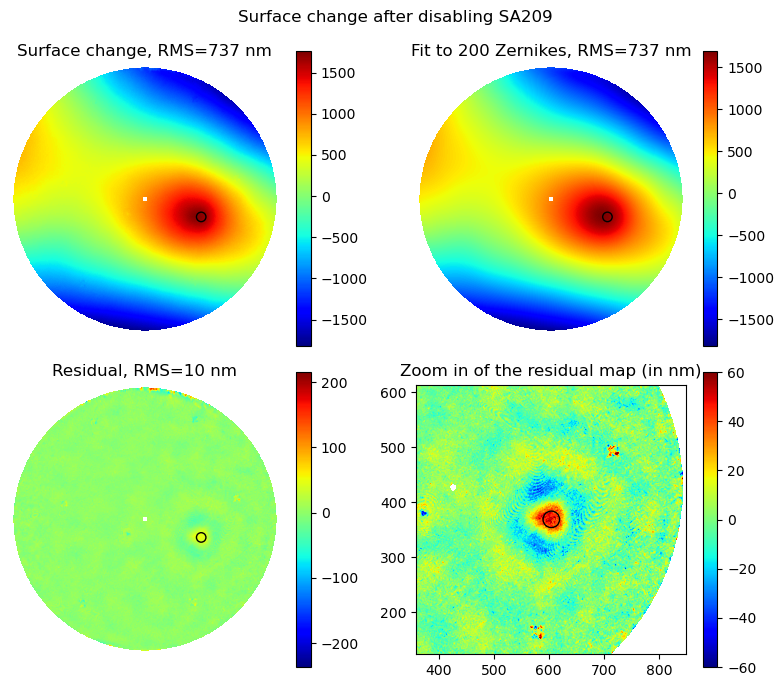

In [97]:
nzerUse = 200
fig, ax = plt.subplots(2,2,figsize=(8,7))
irow = 0
icol = 0
img = ax[irow][icol].imshow(m1s*1000, origin='lower')
fig.colorbar(img, ax=ax[irow][icol])
fig.suptitle('Surface change after disabling SA%d'%mysaID)
m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
ax[irow][icol].set_title('Surface change, RMS=%.0f nm'%(m1rms))
ax[irow][icol].axis('off')

irow = 0
icol = 1
maskNew = (~np.isnan(m1s) ) & (r1<radius_of_CA)
nnodesNew = np.sum(maskNew)
mycoeff = zerU[maskNew.flatten(),:nzerUse].transpose() / nnodesNew @ m1s[maskNew]
recon = np.zeros_like(m1s)
recon[~maskNew] = np.nan
for k in range(nzerUse):
    recon[maskNew] += mycoeff[k]*zerU[maskNew.flatten(),k]  
img = ax[irow][icol].imshow(recon*1000, origin='lower')          
fig.colorbar(img, ax=ax[irow][icol])
m1rms = np.std(recon[~np.isnan(recon)])*1000 #convert into nm
ax[irow][icol].set_title('Fit to %d Zernikes, RMS=%.0f nm'%(nzerUse, m1rms))
ax[irow][icol].axis('off')

irow = 1
icol = 0
residual = m1s-recon
img = ax[irow][icol].imshow(residual*1000, origin='lower')
fig.colorbar(img, ax=ax[irow][icol])
m1rms = np.std(residual[~np.isnan(residual)])*1000 #convert into nm
ax[irow][icol].set_title('Residual, RMS=%.0f nm'%(m1rms))
ax[irow][icol].axis('off')

irow = 1
icol = 1
xx = saID2pixx(mysaID, centerRow, centerCol, pixelSize)
yy = saID2pixy(mysaID, centerRow, centerCol, pixelSize)
d = 245
ymax = np.min((int(yy)+d, Syn))
xmax = np.min((int(xx)+d, Sxn))
aa = residual[ymax-2*d:ymax, xmax-2*d:xmax]

img = ax[irow][icol].imshow(aa*1000, extent=[xmax-2*d, xmax, ymax-2*d, ymax], origin='lower', vmin=-60, vmax=60)

fig.colorbar(img, ax=ax[irow][icol])
ax[irow][icol].set_title('Zoom in of the residual map (in nm)')

for i in range(2):
    for j in range(2):
        circle = plt.Circle((saID2pixx(mysaID, centerRow, centerCol, pixelSize), 
                             saID2pixy(mysaID, centerRow, centerCol, pixelSize)),15, fill=False)
        ax[i][j].add_artist(circle)
    
if 0:
    ax[2].plot(np.arange(1,nzer+1),mycoeff,'-o')
    ax[2].set_title('Zernike change after holding BM14 for 1.5 h')
    ax[2].grid()
    ax[2].set_ylabel(r'$\mu$m')
    ax[2].set_xlabel('Noll Zernike Index')
plt.tight_layout()

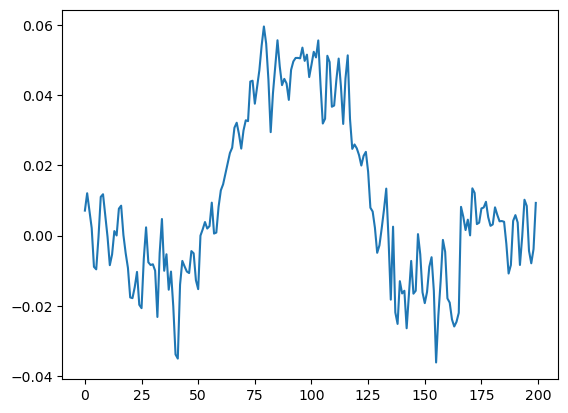

In [76]:
plt.plot(aa[100,:])

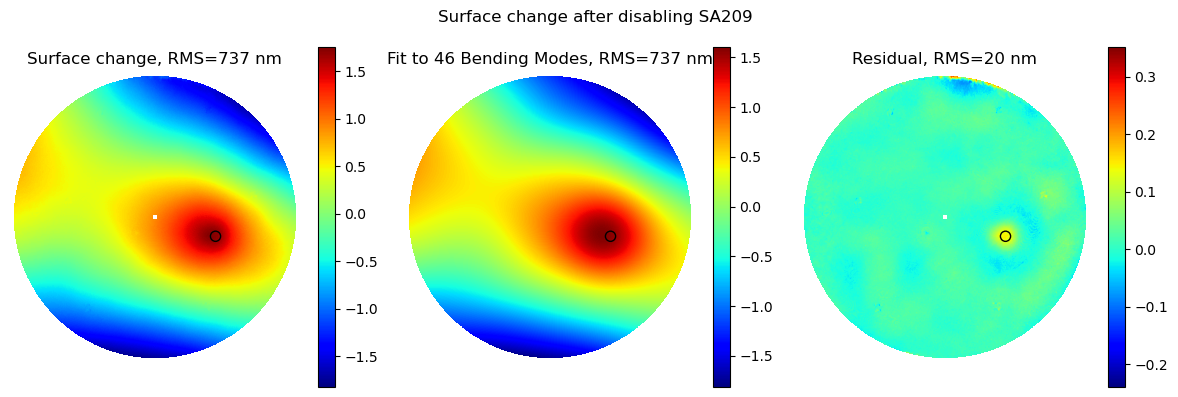

In [21]:
from scipy.interpolate import LinearNDInterpolator 

nfitmode = 46

xtalk = np.zeros((nfitmode, 2))

fig, ax = plt.subplots(1,3,figsize=(12,4))
img = ax[0].imshow(m1s, origin='lower')
fig.colorbar(img, ax=ax[0])
fig.suptitle('Surface change after disabling SA%d'%mysaID)
m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
ax[0].set_title('Surface change, RMS=%.0f nm'%(m1rms))
ax[0].axis('off')

ii = 0 #we only use ii=0, not ii=1
mask = ~np.isnan(m1s)
interp = LinearNDInterpolator(list(zip(x1[mask], y1[mask])), m1s[mask], fill_value=np.nan)
mapOntoGMTFEgrid = interp(nodex, nodey).ravel()
validIdx = ~np.isnan(mapOntoGMTFEgrid)
xtalk[:,ii] = UMat[validIdx,:nfitmode].transpose() /np.sum(validIdx)  @ mapOntoGMTFEgrid[validIdx] #all in micron
recon = UMat[:,:nfitmode] @ xtalk[:, ii]
residual = mapOntoGMTFEgrid - recon #this is residual in micron

aa = recon
m1rms = np.std(aa[~np.isnan(aa)])
grid_z = griddata((nodex, nodey), aa, (x1,y1), method='linear')

img = ax[1].imshow(grid_z, origin='lower')          
fig.colorbar(img, ax=ax[1])
m1rms = np.std(recon[~np.isnan(recon)])*1000 #convert into nm
ax[1].set_title('Fit to %d Bending Modes, RMS=%.0fnm'%(nfitmode, m1rms))
ax[1].axis('off')

residual = m1s-grid_z
img = ax[2].imshow(residual, origin='lower')
fig.colorbar(img, ax=ax[2])
m1rms = np.std(residual[~np.isnan(residual)])*1000 #convert into nm
ax[2].set_title('Residual, RMS=%.0fnm'%(m1rms))
ax[2].axis('off')

for i in range(3):
    circle = plt.Circle((saID2pixx(mysaID, centerRow, centerCol, pixelSize), 
                         saID2pixy(mysaID, centerRow, centerCol, pixelSize)),15, fill=False)
    ax[i].add_artist(circle)
    
plt.tight_layout()

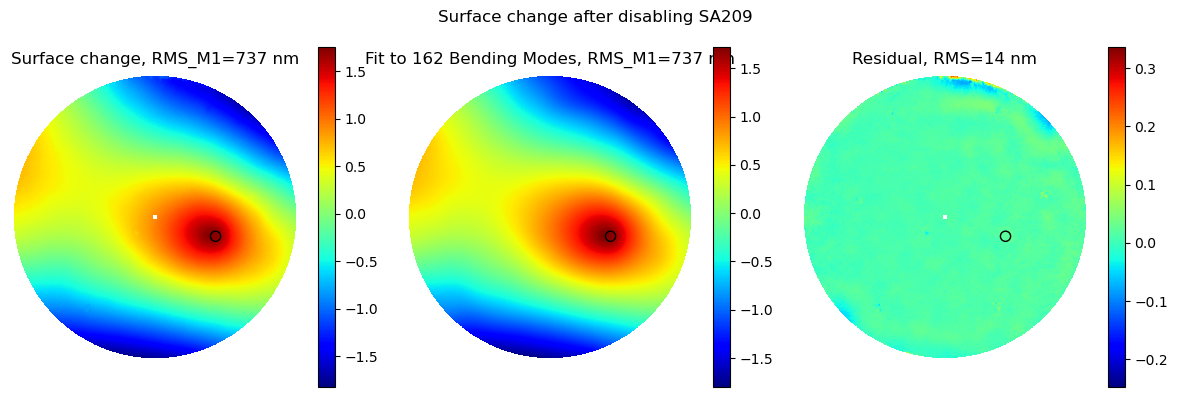

In [20]:
nfitmode = 162

xtalk = np.zeros((nfitmode, 2))

fig, ax = plt.subplots(1,3,figsize=(12,4))
img = ax[0].imshow(m1s, origin='lower')
fig.colorbar(img, ax=ax[0])
fig.suptitle('Surface change after disabling SA%d'%mysaID)
m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
ax[0].set_title('Surface change, RMS_M1=%.0f nm'%(m1rms))
ax[0].axis('off')

ii = 0 #we only use ii=0, not ii=1
mask = ~np.isnan(m1s)
interp = LinearNDInterpolator(list(zip(x1[mask], y1[mask])), m1s[mask], fill_value=np.nan)
mapOntoGMTFEgrid = interp(nodex, nodey).ravel()
validIdx = ~np.isnan(mapOntoGMTFEgrid)
xtalk[:,ii] = UMat[validIdx,:nfitmode].transpose() /np.sum(validIdx)  @ mapOntoGMTFEgrid[validIdx] #all in micron
recon = UMat[:,:nfitmode] @ xtalk[:, ii]
residual = mapOntoGMTFEgrid - recon #this is residual in micron

aa = recon
m1rms = np.std(aa[~np.isnan(aa)])
grid_z = griddata((nodex, nodey), aa, (x1,y1), method='linear')

img = ax[1].imshow(grid_z, origin='lower')          
fig.colorbar(img, ax=ax[1])
m1rms = np.std(recon[~np.isnan(recon)])*1000 #convert into nm
ax[1].set_title('Fit to %d Bending Modes, RMS_M1=%.0f nm'%(nfitmode, m1rms))
ax[1].axis('off')

residual = m1s-grid_z
img = ax[2].imshow(residual, origin='lower')
fig.colorbar(img, ax=ax[2])
m1rms = np.std(residual[~np.isnan(residual)])*1000 #convert into nm
ax[2].set_title('Residual, RMS=%.0f nm'%(m1rms))
ax[2].axis('off')

for i in range(3):
    circle = plt.Circle((saID2pixx(mysaID, centerRow, centerCol, pixelSize), 
                         saID2pixy(mysaID, centerRow, centerCol, pixelSize)),15, fill=False)
    ax[i].add_artist(circle)
    
plt.tight_layout()